##### Importing suicide statistics from WHO API

In [1]:
import requests
import json
import pandas as pd
r = requests.get('http://apps.who.int/gho/athena/api/GHO/MH_12/.json?filter=Year:2016')
data = r.json()

##### Converting JSON data to Python List

In [2]:
list_of_data = []
for fact in data['fact']:
    for category in fact['Dim']:
        if category['category'] == 'COUNTRY':
            country_code = category['code']
        elif category['category'] == "SEX":
            sex = category['code']
    suicide_rate = fact['value']['numeric']
    list_of_data.append({'Country Code': country_code, 'Sex': sex, "Suicide Rate": suicide_rate})

country_codes = []
for country in list_of_data:
    country_codes.append(country['Country Code'])

country_codes = set(country_codes)

data_dictionary = []
for country in country_codes:
    data_dictionary.append({'Country Code': country, 'Male Suicide Rate':'', 'Female Suicide Rate':'', 'Combined Suicide Rate':''})

##### creating Python list with dictionary for each country

In [3]:
for data in list_of_data:
    for country in data_dictionary:
        if data['Country Code'] == country['Country Code']:
            if data['Sex'] == 'MLE':
                country['Male Suicide Rate'] = data['Suicide Rate']
            elif data['Sex'] == "FMLE":
                country['Female Suicide Rate'] = data['Suicide Rate']
            elif data['Sex'] == 'BTSX':
                country['Combined Suicide Rate'] = data['Suicide Rate']

###### Converting to Pandas DataFrame

In [4]:
suicide_rates = pd.DataFrame.from_dict(data_dictionary,)
suicide_rates.set_index(['Country Code'], inplace=True)
suicide_rates.sort_index(inplace=True)

In [5]:
suicide_rates.head()

,Combined Suicide Rate,Female Suicide Rate,Male Suicide Rate
Country Code,,,
AFG,6.4,2.1,10.6
AGO,8.9,4.6,14.0
ALB,5.6,4.3,7.0
ARE,2.7,0.8,3.5
ARG,9.1,3.5,15.0


##### Adding Country name Data and cleaning

In [6]:
r = requests.get('http://apps.who.int/gho/athena/api/GHO/MH_12/.json?filter=Year:2016')
data = r.json()
country_names = []
for country in data['dimension'][4]['code']:
    country_names.append({'Country Code': country['label'], 'Country Name': country['display']})

country_names_df = pd.DataFrame.from_dict(country_names)
country_names_df.set_index('Country Code', inplace=True)

country_names_df.loc[country_names_df.index == "MLT"]

# clean Up Country Names
country_names_df.loc[country_names_df['Country Name'] == "Democratic People's Republic of Korea"] = "North Korea"
country_names_df.loc[country_names_df['Country Name'] == "The former Yugoslav republic of Macedonia"] = "Macedonia"
country_names_df.loc[country_names_df['Country Name'] == "Republic of Moldova"] = "Moldova"
country_names_df.loc[country_names_df['Country Name'] == "Iran (Islamic Republic of)"] = "Iran"
country_names_df.loc[country_names_df['Country Name'] == "Russian Federation"] = "Russia"
country_names_df.loc[country_names_df['Country Name'] == "United Kingdom of Great Britain and Northern Ireland"] = "United Kingdom"
country_names_df.loc[country_names_df['Country Name'] == "Venezuela (Bolivarian Republic of)"] = "Venezuela"
country_names_df.loc[country_names_df['Country Name'] == "United States of America"] = "United States"

country_names_df.tail(15)

suicide_rates = suicide_rates.join(country_names_df)
# suicide_rates

###### Adding country names

In [7]:
suicide_rates = suicide_rates[['Country Name', 'Combined Suicide Rate', 'Male Suicide Rate', 'Female Suicide Rate']]
suicide_rates.head()

,Country Name,Combined Suicide Rate,Male Suicide Rate,Female Suicide Rate
Country Code,,,,
AFG,Afghanistan,6.4,10.6,2.1
AGO,Angola,8.9,14.0,4.6
ALB,Albania,5.6,7.0,4.3
ARE,United Arab Emirates,2.7,3.5,0.8
ARG,Argentina,9.1,15.0,3.5


In [8]:
suicide_rates.shape

(183, 4)

##### importing percentage of population living in cities data from WHO API

In [9]:
r = requests.get('http://apps.who.int/gho/athena/api/GHO/AIR_3/?format=json')
data = r.json()

###### Converting JSON data to Python list

In [10]:
data_dictionary = []
for country in data['fact']:
    for category in country['Dim']:
        if category['category'] == "COUNTRY":
            countrycode = category['code']
    data_dictionary.append({"Country Code": countrycode, "% Living in Cities > 100k": country['value']['numeric']})

In [11]:
data_dictionary[0]

{'Country Code': 'AFG', '% Living in Cities > 100k': 15.56}

###### Converting info to Pandas DataFrame

In [12]:
percent_living_in_cities = pd.DataFrame(data_dictionary)
percent_living_in_cities.set_index(['Country Code'], inplace=True)

###### Combining with suicide stats DataFrame and Changing NaN values to Median

In [13]:
suicide_rates = suicide_rates.join(percent_living_in_cities, on=['Country Code'], how='left')

In [14]:
suicide_rates['% Living in Cities > 100k'].fillna(suicide_rates['% Living in Cities > 100k'].median(), inplace=True)
suicide_rates.isna().sum()

Country Name                 0
Combined Suicide Rate        0
Male Suicide Rate            0
Female Suicide Rate          0
% Living in Cities > 100k    0
dtype: int64

###### Scraping Internet Data from CIA World Fact Book using BeautifulSoup

In [15]:
from bs4 import BeautifulSoup
r = requests.get('https://www.cia.gov/library/publications/the-world-factbook/fields/204.html#AF')
c = r.content
soup = BeautifulSoup(c)

/Users/briansrebrenik/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/briansrebrenik/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [16]:
data = soup.findAll('tr')[1:]

##### Scraping country names and internet connectivity info

In [17]:
data_dictionary = []
for country in data:
    try:
        country_name = country.findAll('td', {'class': 'country'})[0].text
        country_name_formatted = country_name.replace('\n', "")
        internet_percentage = country.findAll('span', {'class': 'subfield-number'})[1].text
        internet_percentage_formatted = float(internet_percentage.replace("%", ""))
        data_dictionary.append({'country': country_name_formatted, "percentage of population with internet access": internet_percentage_formatted})
    except:
        pass

##### Converting to Pandas DataFrame

In [18]:
internet_stats_df = pd.DataFrame.from_dict(data_dictionary)

In [19]:
internet_stats_df.columns= ['Country Name', "% of Population with Internet Access"]
internet_stats_df.set_index(['Country Name'], inplace=True)


In [20]:
internet_stats_df.shape
internet_stats_df.head()

,% of Population with Internet Access
Country Name,
Afghanistan,10.6
Albania,66.4
Algeria,42.9
American Samoa,31.3
Andorra,97.9


##### Combining with other data collected

In [21]:
suicide_rates = suicide_rates.join(internet_stats_df, on=['Country Name'], how='inner')

In [22]:
suicide_rates.sort_values(by = "Country Name", ascending = False)
suicide_rates.shape

(167, 6)

###### Scraping Religous stats

In [23]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
r = requests.get('https://rationalwiki.org/wiki/Importance_of_religion_by_country')
c = r.content
soup = BeautifulSoup(c)

/Users/briansrebrenik/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/briansrebrenik/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [24]:
data = soup.findAll('table', {'class': 'wikitable'})
data = data[0].findAll('td')

In [25]:
religous_stats = []
for i in range(len(data)):
    if i == 0 or i % 3 == 0:
        country = data[i].text.strip()
    elif i in list(range(1, len(data), 3)):
        percentage_religious = float(data[i].text.replace("%", ""))
        religous_stats.append({'Country Name': country, "% Religious": percentage_religious})

In [26]:
religious_df = pd.DataFrame.from_dict(religous_stats)
religious_df.set_index(['Country Name'], inplace=True)
suicide_rates.set_index(['Country Name'], inplace=True)

In [27]:
suicide_rates.head()
religious_df.head()

,% Religious
Country Name,
Estonia,16.0
Sweden,16.5
Denmark,18.0
Czech Republic,20.5
Norway,20.5


###### Combine with rest of data

In [28]:
suicide_rates = suicide_rates.join(religious_df)

In [29]:
suicide_rates.sort_values(by = "Country Name", ascending = False)
suicide_rates.head()

,Combined Suicide Rate,Male Suicide Rate,Female Suicide Rate,% Living in Cities > 100k,% of Population with Internet Access,% Religious
Country Name,,,,,,
Afghanistan,6.4,10.6,2.1,15.56,10.6,97.0
Angola,8.9,14.0,4.6,19.97,13.0,88.0
Albania,5.6,7.0,4.3,9.34,66.4,32.5
United Arab Emirates,2.7,3.5,0.8,70.03,90.6,91.0
Argentina,9.1,15.0,3.5,74.17,70.2,66.0


##### Getting Economic and Health Data

In [30]:
gdp_url = "https://www.cia.gov/library/publications/the-world-factbook/rankorder/rawdata_2004.txt"
unemp_url = "https://www.cia.gov/library/publications/the-world-factbook/rankorder/rawdata_2129.txt"

import urllib  # the lib that handles the url stuff
import json
import pandas as pd
import numpy as np
from xml.dom import minidom
from urllib.request import urlopen
import matplotlib.pyplot as plt
%matplotlib inline


GDP = pd.read_fwf('gdp_perca.txt', header = None, names = ['country', 'GDP']).astype(str)
Unemp = pd.read_fwf('unemp.txt', header = None, names = ['Unem_rate'])
mental = pd.read_csv('mental_disorder_substance_use.csv')
healthcare = pd.read_excel('NHA.xlsx')

      
index_list = [item[1] for item in Unemp.index]
Unemp.index = index_list
Unemp.head()

gdp = GDP.set_index('country')
health = healthcare[["Countries", '2016']]
nha = health.drop([0], axis = 0)

##### Cleaning data and putting it in Data Frame

In [31]:
mental1 = mental[mental.Year == 2016]
mental1.dropna(axis = 0, inplace = True)
men_copy = mental1.set_index('Entity')

/Users/briansrebrenik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### Mergin Tables and cleaning new data

In [32]:
merged = men_copy.join(Unemp)
merged.drop('Year', axis = 1, inplace = True)
merged = merged.join(gdp)
merged.dropna(inplace = True)

#GDP per capita
gdps = [item.split(",") for item in merged.GDP]

def clean_gdp(data):
    empty = []
    for item in data:
        first = item[0].split("$")[1]
        second = item[1]
        total = int(first+second)
        empty.append(total)
    return empty

merged.GDP = clean_gdp(gdps)
merged.sort_values(by = "Entity", ascending = False)
merged[merged.Code == "RUS"]

#Health spending per capita
health = nha.set_index('Countries')
health.rename(columns = {'2016': 'health_spend_perca'}, inplace = True)


new = merged.join(health)
new.loc["Russia", 'health_spend_perca'] = 1414.12
new[new.index == "Russia"]
new.loc["United States", 'health_spend_perca'] = 9869.74
len(new)
final = new.dropna()

In [33]:
suicide_rates.head()

,Combined Suicide Rate,Male Suicide Rate,Female Suicide Rate,% Living in Cities > 100k,% of Population with Internet Access,% Religious
Country Name,,,,,,
Afghanistan,6.4,10.6,2.1,15.56,10.6,97.0
Angola,8.9,14.0,4.6,19.97,13.0,88.0
Albania,5.6,7.0,4.3,9.34,66.4,32.5
United Arab Emirates,2.7,3.5,0.8,70.03,90.6,91.0
Argentina,9.1,15.0,3.5,74.17,70.2,66.0


##### Mergin FInal Two Tables

In [34]:
final_table = final.join(suicide_rates)
final_table.head()
final_table.dropna(subset = ['Combined Suicide Rate'], inplace = True)
final_table['% Religious'].fillna(50, inplace = True)
final_table.head()

,Code,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%),Unem_rate,GDP,health_spend_perca,Combined Suicide Rate,Male Suicide Rate,Female Suicide Rate,% Living in Cities > 100k,% of Population with Internet Access,% Religious
Entity,,,,,,,,,,,,,,,,,
Afghanistan,AFG,0.159494,0.760363,0.088103,5.023055,1.196912,4.404727,0.612712,23.9,2000,57.2488,6.4,10.6,2.1,15.56,10.6,97.0
Albania,ALB,0.231592,0.667222,0.113824,3.557997,0.655556,2.450883,1.669982,14.0,12500,271.543,5.6,7.0,4.3,9.34,66.4,32.5
Algeria,DZA,0.199488,0.868839,0.181441,5.249815,0.880553,3.946200,0.605362,11.7,15200,260.413,3.3,4.9,1.8,24.73,42.9,93.0
Angola,AGO,0.198776,0.623446,0.113965,3.272275,0.467204,4.715467,1.456741,6.6,6800,95.2208,8.9,14.0,4.6,19.97,13.0,88.0
Antigua and Barbuda,ATG,0.210017,0.930308,0.210369,4.316763,0.719728,3.128054,1.947655,11.0,26300,623.115,0.5,0.0,0.9,33.07,65.2,50.0


In [35]:
final_table.loc[final_table["% Religious"] > 33, "Religious"] = "Medium"
final_table.loc[final_table["% Religious"] >= 66, "Religious"] = "High"
final_table.loc[final_table["% Religious"] <= 33, "Religious"] = "Low"

In [36]:
final_table.head()

,Code,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%),Unem_rate,GDP,health_spend_perca,Combined Suicide Rate,Male Suicide Rate,Female Suicide Rate,% Living in Cities > 100k,% of Population with Internet Access,% Religious,Religious
Entity,,,,,,,,,,,,,,,,,,
Afghanistan,AFG,0.159494,0.760363,0.088103,5.023055,1.196912,4.404727,0.612712,23.9,2000,57.2488,6.4,10.6,2.1,15.56,10.6,97.0,High
Albania,ALB,0.231592,0.667222,0.113824,3.557997,0.655556,2.450883,1.669982,14.0,12500,271.543,5.6,7.0,4.3,9.34,66.4,32.5,Low
Algeria,DZA,0.199488,0.868839,0.181441,5.249815,0.880553,3.946200,0.605362,11.7,15200,260.413,3.3,4.9,1.8,24.73,42.9,93.0,High
Angola,AGO,0.198776,0.623446,0.113965,3.272275,0.467204,4.715467,1.456741,6.6,6800,95.2208,8.9,14.0,4.6,19.97,13.0,88.0,High
Antigua and Barbuda,ATG,0.210017,0.930308,0.210369,4.316763,0.719728,3.128054,1.947655,11.0,26300,623.115,0.5,0.0,0.9,33.07,65.2,50.0,Medium


##### Checking for Multicolinearity and removing excess features

In [37]:
abs(final_table.corr()) > 0.75

,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%),Unem_rate,GDP,Combined Suicide Rate,Male Suicide Rate,Female Suicide Rate,% Living in Cities > 100k,% of Population with Internet Access,% Religious
Schizophrenia (%),True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Bipolar disorder (%),False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
Eating disorders (%),False,True,True,False,False,False,False,False,True,False,False,False,False,False,False
Anxiety disorders (%),False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
Drug use disorders (%),False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
Depression (%),False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
Alcohol use disorders (%),False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
Unem_rate,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
GDP,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False
Combined Suicide Rate,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False


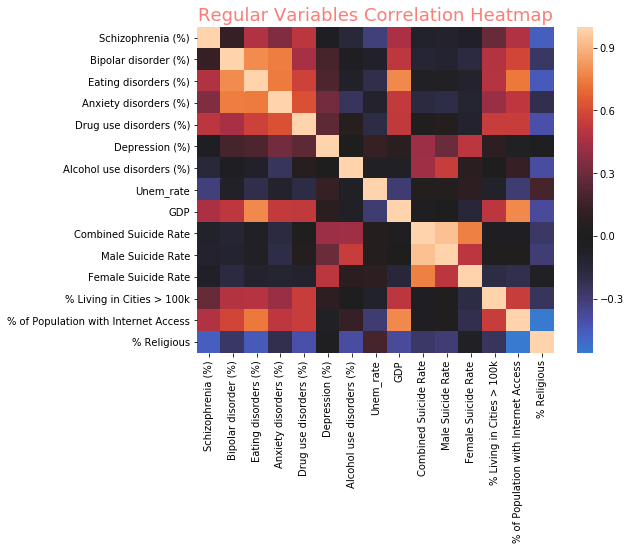

In [38]:
import seaborn as sns
plt.figure(figsize = (8,6))
plt.title("Regular Variables Correlation Heatmap", fontsize = 18, color = "#F97E77")
sns.heatmap(final_table.corr(), center = 0)

##### Drop "Bipoar Disorder" since it has very high corelation with 3 other variables.

In [39]:
final_table.drop("Bipolar disorder (%)", axis = 1, inplace = True)

##### Clean up Some Column Names with too many signs and letters

In [40]:
final_table.rename(columns = {'Schizophrenia (%)': 'Schizophrenia'}, inplace = True)
final_table.rename(columns = {'Eating disorders (%)': 'Eating_disorders'}, inplace = True)
final_table.rename(columns = {'Anxiety disorders (%)': 'Anxiety'}, inplace = True)
final_table.rename(columns = {'Drug use disorders (%)': 'Drug_use'}, inplace = True)
final_table.rename(columns = {'Depression (%)': 'Depression'}, inplace = True)
final_table.rename(columns = {'Alcohol use disorders (%)': 'Alcohol_use'}, inplace = True)
final_table.rename(columns = {'Combined Suicide Rate': 'Combined_suicide_rate'}, inplace = True)
final_table.rename(columns = {'% Living in Cities > 100k': 'urban_population'}, inplace = True)
final_table.rename(columns = {'% of Population with Internet Access': 'Internet_access_percap'}, inplace = True)

In [41]:
final_table.head()

,Code,Schizophrenia,Eating_disorders,Anxiety,Drug_use,Depression,Alcohol_use,Unem_rate,GDP,health_spend_perca,Combined_suicide_rate,Male Suicide Rate,Female Suicide Rate,urban_population,Internet_access_percap,% Religious,Religious
Entity,,,,,,,,,,,,,,,,,
Afghanistan,AFG,0.159494,0.088103,5.023055,1.196912,4.404727,0.612712,23.9,2000,57.2488,6.4,10.6,2.1,15.56,10.6,97.0,High
Albania,ALB,0.231592,0.113824,3.557997,0.655556,2.450883,1.669982,14.0,12500,271.543,5.6,7.0,4.3,9.34,66.4,32.5,Low
Algeria,DZA,0.199488,0.181441,5.249815,0.880553,3.946200,0.605362,11.7,15200,260.413,3.3,4.9,1.8,24.73,42.9,93.0,High
Angola,AGO,0.198776,0.113965,3.272275,0.467204,4.715467,1.456741,6.6,6800,95.2208,8.9,14.0,4.6,19.97,13.0,88.0,High
Antigua and Barbuda,ATG,0.210017,0.210369,4.316763,0.719728,3.128054,1.947655,11.0,26300,623.115,0.5,0.0,0.9,33.07,65.2,50.0,Medium


In [42]:
final_table.shape

(148, 17)

##### Dropping columns we don't need

In [43]:
test_table = final_table.drop(columns=['Code', "Male Suicide Rate", "Female Suicide Rate", "% Religious"])

##### Changing health_spend_perca column to float64 so we can do calcualtions

In [44]:
test_table.health_spend_perca = test_table.health_spend_perca.map(lambda x: float(x))
test_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, Afghanistan to Zimbabwe
Data columns (total 13 columns):
Schizophrenia             148 non-null float64
Eating_disorders          148 non-null float64
Anxiety                   148 non-null float64
Drug_use                  148 non-null float64
Depression                148 non-null float64
Alcohol_use               148 non-null float64
Unem_rate                 148 non-null float64
GDP                       148 non-null int64
health_spend_perca        148 non-null float64
Combined_suicide_rate     148 non-null float64
urban_population          148 non-null float64
Internet_access_percap    148 non-null float64
Religious                 148 non-null object
dtypes: float64(11), int64(1), object(1)
memory usage: 16.2+ KB


##### Creating Dummy variables and dropping one of them plus the main category column

In [45]:
dummies = pd.get_dummies(test_table['Religious'], prefix="Rel")
test_table = pd.concat([test_table, dummies], axis=1)
test_table.drop(columns=['Religious', ], inplace=True)
test_table.drop(columns=['Rel_Low'], inplace=True)

##### Move target colum to the end of table for easier DataFrame navigation

In [46]:
target = test_table['Combined_suicide_rate']
test_table.drop(columns=['Combined_suicide_rate'], inplace=True)
test_table = pd.concat([test_table, target], axis=1)
test_table.head()

,Schizophrenia,Eating_disorders,Anxiety,Drug_use,Depression,Alcohol_use,Unem_rate,GDP,health_spend_perca,urban_population,Internet_access_percap,Rel_High,Rel_Medium,Combined_suicide_rate
Entity,,,,,,,,,,,,,,
Afghanistan,0.159494,0.088103,5.023055,1.196912,4.404727,0.612712,23.9,2000,57.248760,15.56,10.6,1,0,6.4
Albania,0.231592,0.113824,3.557997,0.655556,2.450883,1.669982,14.0,12500,271.543043,9.34,66.4,0,0,5.6
Algeria,0.199488,0.181441,5.249815,0.880553,3.946200,0.605362,11.7,15200,260.412579,24.73,42.9,1,0,3.3
Angola,0.198776,0.113965,3.272275,0.467204,4.715467,1.456741,6.6,6800,95.220799,19.97,13.0,1,0,8.9
Antigua and Barbuda,0.210017,0.210369,4.316763,0.719728,3.128054,1.947655,11.0,26300,623.114626,33.07,65.2,0,1,0.5


##### Plot a pairplot of dependent variable to independent variables scatterplot relationships

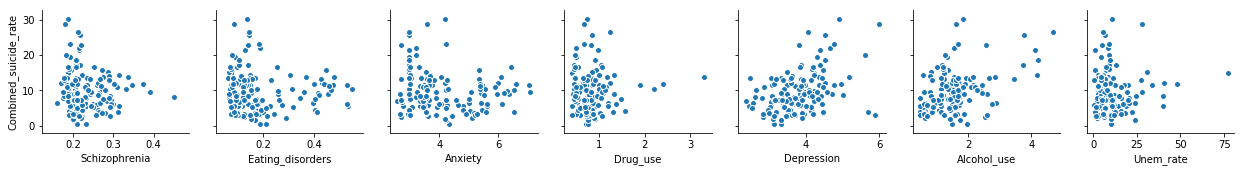

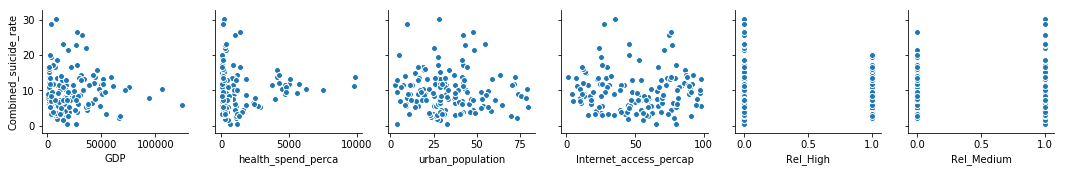

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

variables = list(test_table.columns)[:-1]
sns.pairplot(test_table, x_vars=variables[:7], y_vars=['Combined_suicide_rate'])
sns.pairplot(test_table, x_vars=variables[7:], y_vars=['Combined_suicide_rate'])


##### Starting our LinearRgegression process by creating a set of polynomial variables to the power = 2

In [48]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing, pipeline

poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_poly = pd.DataFrame(poly.fit_transform(test_table.drop(columns=['Combined_suicide_rate'])), columns=poly.get_feature_names(test_table.drop(columns=['Combined_suicide_rate']).columns))

X_poly= features_poly
y= test_table['Combined_suicide_rate']

##### Check for Multicollinearity of the Polynomial variables

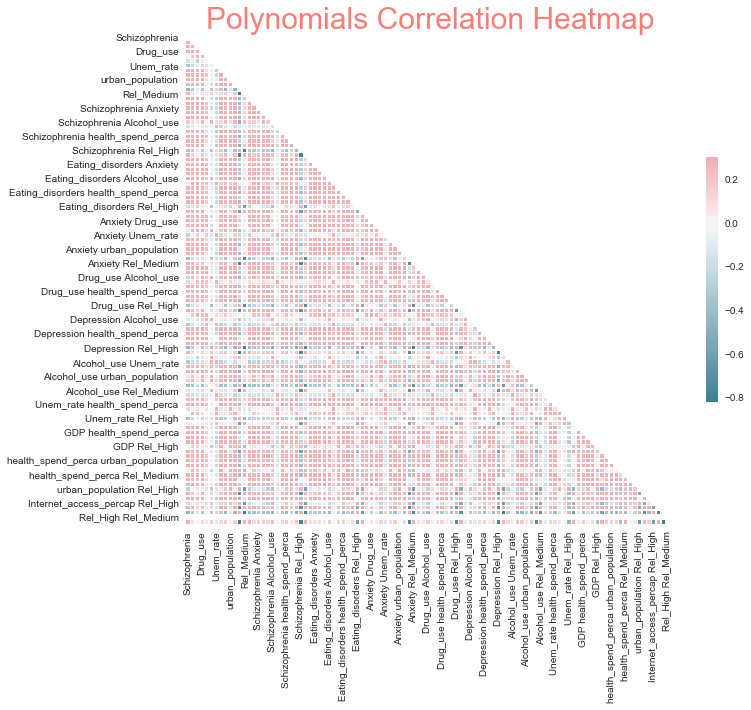

In [49]:
import seaborn as sns

sns.set(style="white")


# Compute the correlation matrix
corr = features_poly.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plt.title("Polynomials Correlation Heatmap", fontsize = 30, color = "#F97E77")
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

##### Drop any variable with a .corr() > 0.95

In [50]:
# Create correlation matrix
corr_matrix = features_poly.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

#Drop variables from table
X_poly.drop(columns=to_drop, inplace=True)
X_poly.shape

(148, 73)

##### Run Linear Regression Model (80-20 split) and use Cross validation to find model with smallest RMSE

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

X_poly = X_poly
y = test_table['Combined_suicide_rate']

def MSE_test(X_poly, y, random_state = 11):
    poly_RSME = []
    for i in range(1, len(X_poly.columns)):
        linreg = LinearRegression()
        selector = RFE(linreg, n_features_to_select = i)
        selector = selector.fit(X_poly, y)
        selected_columns = X_poly.columns[selector.support_]
        selected_var = [column for column in selected_columns]
        X_train, X_test, y_train, y_test = train_test_split(X_poly[selected_columns], y, random_state = random_state,  test_size=.20)
        linreg.fit(X_train, y_train)
        cv_50_results = np.mean(cross_val_score(linreg, X_train, y_train, cv=50, scoring='neg_mean_squared_error'))
        cv_50_results= np.sqrt(abs(cv_50_results))
        poly_RSME.append(dict(variables = selected_var, RMSE = cv_50_results, nu_var = len( selected_var)))
    return poly_RSME

poly_model_list = MSE_test(X_poly, y)

def find_best_model(model_list):
    sorted_mse = sorted(model_list, key=lambda k: k['RMSE'])
    return sorted_mse[0]
    
find_best_model(poly_model_list)

{'variables': ['Schizophrenia',
  'Eating_disorders',
  'Drug_use',
  'Depression',
  'Alcohol_use',
  'Rel_High',
  'Schizophrenia Drug_use',
  'Schizophrenia Depression',
  'Schizophrenia Alcohol_use',
  'Eating_disorders Drug_use',
  'Eating_disorders Rel_Medium',
  'Anxiety Rel_High'],
 'RMSE': 4.50314817549529,
 'nu_var': 12}

##### Graph the minimized RMSE agains number of selected variables

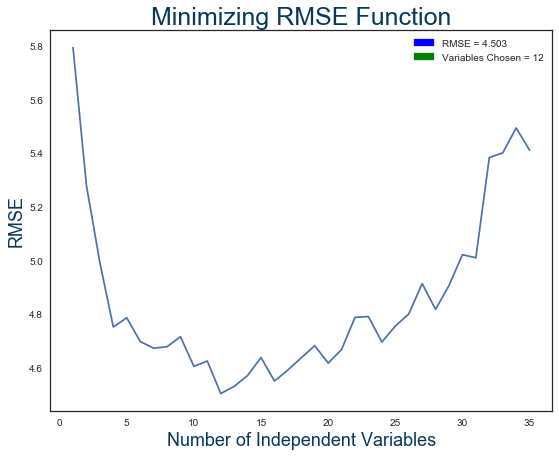

In [52]:
import matplotlib.patches as mpatches

min_rmse = find_best_model(poly_model_list)['RMSE']
min_var = find_best_model(poly_model_list)['nu_var']
x_val = [item['nu_var'] for item in poly_model_list[:35]]
y_val = [item['RMSE'] for item in poly_model_list[:35]]
plt.figure(figsize = (9,7))
plt.title("Minimizing RMSE Function", fontsize = 25, color = "#073A5A")
plt.plot(x_val, y_val)
plt.xlabel("Number of Independent Variables", fontsize = 18, color = "#073A5A")
plt.ylabel("RMSE", fontsize = 18, color = "#073A5A")

rmse_patch = mpatches.Patch(color='blue', label="RMSE = {}".format(round(min_rmse, 3)))
vars_patch = mpatches.Patch(color='green', label="Variables Chosen = {}".format(min_var))
plt.legend(handles=[rmse_patch, vars_patch])


##### Now Test the model against the test data alone and return R2, z_score, and RMSE

In [53]:
selected_variables = find_best_model(poly_model_list)['variables']
selected_variables
X_train, X_test, y_train, y_test = train_test_split(X_poly[selected_variables], y, random_state = 11,  test_size=.20)
linreg = LinearRegression()
linreg.fit(X_train[selected_variables], y_train)
yhat = linreg.predict(X_test[selected_variables])

RMSE = np.sqrt(mean_squared_error(y_test, yhat))
z_score = RMSE/np.std(y_test)
R_squared = linreg.score(X_test, y_test)
print("RMSE = {}, z_score = {}, R_squared = {}".format(RMSE, z_score, R_squared))

RMSE = 3.7237785262479655, z_score = 0.6528359506725786, R_squared = 0.5738052215094305


##### Graph our final results as a scatterplot of y_test and y_train values vs. y_hat_values and comparing Bias and Variance scores

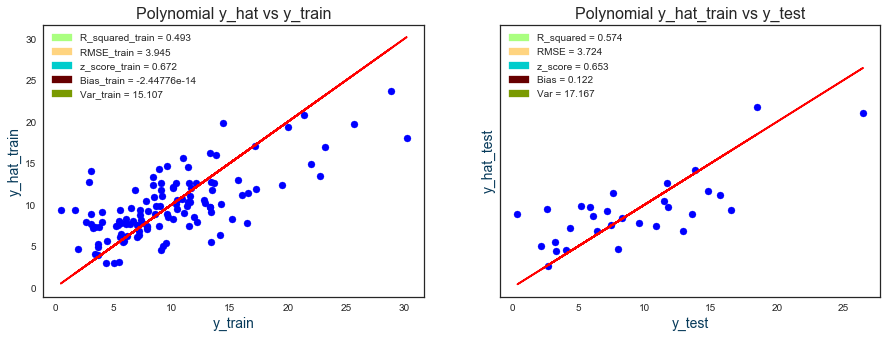

In [54]:
import matplotlib.patches as mpatches

def bias(y, y_hat):
    return np.mean(y_hat - y)

def variance(y_hat):
    return np.mean([yi**2 for yi in y_hat]) - np.mean(y_hat)**2

selected_columns = find_best_model(poly_model_list)['variables']
X_train, X_test, y_train, y_test = train_test_split(X_poly[selected_columns], y, random_state = 11,  test_size=.20)

reg = LinearRegression().fit(X_train, y_train)

y_hat_train = reg.predict(X_train)
y_hat_test = reg.predict(X_test)
bias_train = bias(y_train, y_hat_train)
bias_test = bias(y_test, y_hat_test)
var_train = variance(y_hat_train)
var_test = variance(y_hat_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_hat_train))
z_score_train = RMSE/np.std(y_train)
R_squared_train = linreg.score(X_train, y_train)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (15,5))

ax1.set_title("Polynomial y_hat vs y_train", fontsize = 16)
ax1.set_xlabel("y_train",fontsize = 14, color = "#073A5A")
ax1.set_ylabel("y_hat_train",fontsize = 14, color = "#073A5A")
ax1.scatter(y_train, y_hat_train, color = "blue", label='Actual Data')
ax1.plot(y_train, y_train, color = "red", label='Model')

R2_patch = mpatches.Patch(color='#aaff80', label="R_squared_train = {}".format(round(R_squared_train, 3)))
RMSE_patch = mpatches.Patch(color='#ffd480', label="RMSE_train = {}".format(round(RMSE_train, 3)))
z_patch = mpatches.Patch(color='#00cccc', label="z_score_train = {}".format(round(z_score_train, 3)))
Bias_patch = mpatches.Patch(color='#670000', label="Bias_train = {}".format(round(bias_train, 20)))
Variance_patch = mpatches.Patch(color='#7A9A01', label="Var_train = {}".format(round(var_train, 3)))

ax1.legend(handles=[R2_patch, RMSE_patch, z_patch, Bias_patch, Variance_patch])

ax2.set_title("Polynomial y_hat_train vs y_test", fontsize = 16)
ax2.set_xlabel("y_test", fontsize = 14, color = "#073A5A")
ax2.set_ylabel("y_hat_test", fontsize = 14, color = "#073A5A")
ax2.scatter(y_test, y_hat_test, color = "blue")
ax2.plot(y_test, y_test, color = "red")

R2_patch = mpatches.Patch(color='#aaff80', label="R_squared = {}".format(round(R_squared, 3)))
RMSE_patch = mpatches.Patch(color='#ffd480', label="RMSE = {}".format(round(RMSE, 3)))
z_patch = mpatches.Patch(color='#00cccc', label="z_score = {}".format(round(z_score, 3)))
Bias_patch = mpatches.Patch(color='#670000', label="Bias = {}".format(round(bias_test, 3)))
Variance_patch = mpatches.Patch(color='#7A9A01', label="Var = {}".format(round(var_test, 3)))

ax2.legend(handles=[R2_patch, RMSE_patch, z_patch,  Bias_patch, Variance_patch], loc = "upper left")



##### Print our final equation to get a sense of individual variable relationships

In [55]:
test = list(zip(linreg.coef_, selected_variables))
combined = [str(round(item[0], 2)) + "*" +item[1] for item in test]
one_string = "  +  ".join(combined)
equation = one_string.replace("+  -", "-  ")

In [56]:
print("y = {} + {}".format(round(linreg.intercept_, 2), equation))

y = -40.77 + 133.96*Schizophrenia  +  20.41*Eating_disorders  -  7.3*Drug_use  +  13.12*Depression  +  6.71*Alcohol_use  +  4.92*Rel_High  +  45.19*Schizophrenia Drug_use  -  41.29*Schizophrenia Depression  -  18.44*Schizophrenia Alcohol_use  -  17.52*Eating_disorders Drug_use  -  2.92*Eating_disorders Rel_Medium  -  1.91*Anxiety Rel_High


##### Plot a Barchart of Independent variables to visualize Variable weight

<BarContainer object of 12 artists>

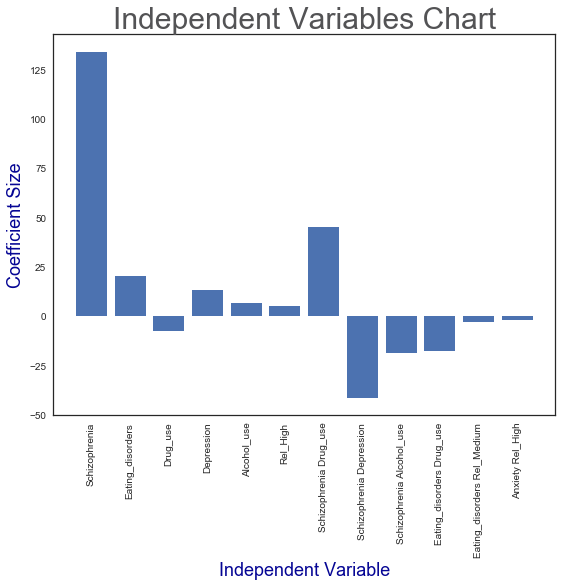

In [57]:
coefs = [item[0] for item in test]
varias = [item[1] for item in test]
plt.figure(figsize = (9,7))
plt.title("Independent Variables Chart", fontsize = 30, color = "#535355")
plt.xlabel("Independent Variable", fontsize = 18, color = "#050594")
plt.ylabel("Coefficient Size", fontsize = 18, color = "#050594")
plt.xticks(rotation=90)
plt.bar(varias, coefs)


###                                        HURRAY!!!  WE DONE!!!